In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ast import literal_eval
from sklearn.metrics import auc
import numpy as np
from matplotlib.ticker import MaxNLocator

In [2]:
np.random.seed(42)

In [3]:
controller_output = Path('output')

In [4]:
lowest_cost_df = pd.read_csv(controller_output / '100_runs_lowest_utility.csv')
highest_cost_df = pd.read_csv(controller_output / '100_runs_highest_utility.csv')

In [5]:
random_cost_dfs = []
for random_run in controller_output.glob('100_runs_random_utility*.csv'):
    random_cost_dfs.append(pd.read_csv(random_run))

## Rule Picking Strategies (for choosing action per issue)

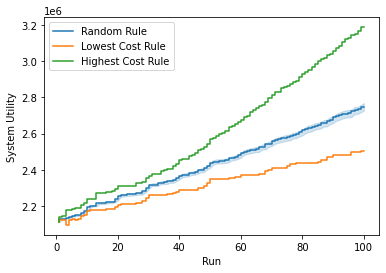

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='run', y='system_utility', data=pd.concat(random_cost_dfs), ci=95, ax=ax, drawstyle='steps', label='Random Rule')
sns.lineplot(x='run', y='system_utility', data=lowest_cost_df, ax=ax, ci=None, drawstyle='steps', label='Lowest Cost Rule')
sns.lineplot(x='run', y='system_utility', data=highest_cost_df, ax=ax, ci=None, drawstyle='steps', label='Highest Cost Rule')
ax.set(xlabel='Run', ylabel='System Utility');
fig.savefig(controller_output / 'sys_util_over_runs_rule_choice.png', dpi=300)

## Issue Ranking Strategies

In [7]:
low_u_df = pd.read_csv(controller_output / '100_runs_lowest_utility.csv')
low_c_df = pd.read_csv(controller_output / '100_runs_lowest_cost.csv')
low_r_df = pd.read_csv(controller_output / '100_runs_lowest_random.csv')

In [8]:
for df in [low_u_df, low_c_df, low_r_df]:
    df['combined_index'] = 'after fixing ' + df['failure_name'].astype(str) + ' (' + df['shop'].astype(str) + ')'
    df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'] = df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'].apply(literal_eval)

In [9]:
def calculate_estimated_utility_within_run(df, run, strategy='utility'):
    run = df.query(f'run == {run}').copy()
    rows_with_fixes = run.loc[~run['predicted_optimal_utility'].isna()].copy()
    rows_with_fixes['min_cost'] = rows_with_fixes['rule_costs'].apply(min)
    if strategy == 'utility':
        rows_with_fixes = rows_with_fixes.sort_values(['predicted_optimal_utility'], ascending=False)
    elif strategy == 'cost':
        rows_with_fixes = rows_with_fixes.sort_values(['min_cost'], ascending=True)
    elif strategy == 'random':
        rows_with_fixes = rows_with_fixes.sample(frac=1)
    else:
        raise NotImplementedError('Strategy {strategy} is not implemented')
    rows_with_fixes['estimated_system_utility'] = rows_with_fixes['system_utility'] + rows_with_fixes['predicted_optimal_utility'].fillna(0).cumsum()
    if len(rows_with_fixes) > 1:
        rows_with_fixes['auc'] = auc(x=np.arange(len(rows_with_fixes)), y=rows_with_fixes['estimated_system_utility'].values)
    else:
        rows_with_fixes['auc'] = np.nan
    return rows_with_fixes

In [10]:
def estimate_system_utility_for_all_runs(df, strategy):
    return pd.concat([calculate_estimated_utility_within_run(df, run, strategy) for run in df['run'].unique()])

In [11]:
low_u_estimates_df = estimate_system_utility_for_all_runs(low_u_df, 'utility')\
    .reset_index()[['run', 'estimated_system_utility', 'auc']]\
    .reset_index().rename(columns={'index': 'fixed_issues'})
low_c_estimates_df = estimate_system_utility_for_all_runs(low_c_df, 'cost')\
    .reset_index()[['run', 'estimated_system_utility', 'auc']]\
    .reset_index().rename(columns={'index': 'fixed_issues'})

In [12]:
n_random_approach_simulations = 30
random_approach_simulations = []
for i in range(n_random_approach_simulations):
    random_approach_simulations.append(estimate_system_utility_for_all_runs(low_r_df, strategy='random'))
low_r_estimates_df = pd.concat(random_approach_simulations)\
                       .groupby(['run', 'fix_status', 'shop', 'component'])\
                       .mean()\
                       .reset_index()[['run', 'auc', 'estimated_system_utility']]\
                       .reset_index().rename(columns={'index': 'fixed_issues'})

In [13]:
for df in [low_u_estimates_df, low_c_estimates_df, low_r_estimates_df]:
    df['fixed_issues'] += 1
    df['issues_in_run'] = df.groupby('run')['fixed_issues'].transform('nunique')
    df['auc_vs_random'] = df['auc'] - low_r_estimates_df['auc']
    df['util_vs_random'] = df['estimated_system_utility'] - low_r_estimates_df['estimated_system_utility']

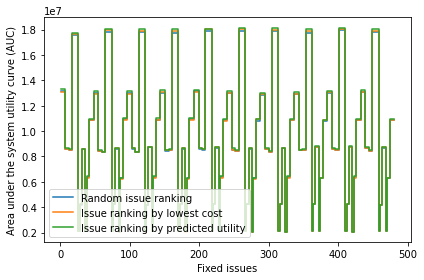

In [14]:
fig, ax = plt.subplots()
sns.lineplot(x='fixed_issues', y='auc', data=low_r_estimates_df, ax=ax, ci=None, label='Random issue ranking', drawstyle='steps')
sns.lineplot(x='fixed_issues', y='auc', data=low_c_estimates_df, ax=ax, ci=None, label='Issue ranking by lowest cost', drawstyle='steps')
sns.lineplot(x='fixed_issues', y='auc', data=low_u_estimates_df, ax=ax, ci=None, label='Issue ranking by predicted utility', drawstyle='steps')
ax.set(xlabel='Fixed issues', ylabel='Area under the system utility curve (AUC)');
fig.tight_layout()
fig.savefig(controller_output / 'auc_over_runs.png', dpi=300)

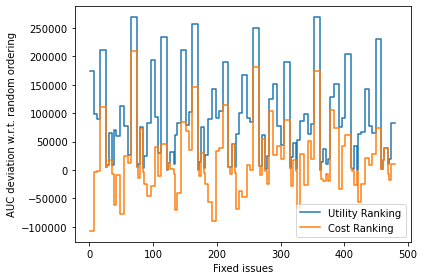

In [15]:
fig, ax = plt.subplots()
sns.lineplot(x='fixed_issues', y='auc_vs_random', data=low_u_estimates_df, ax=ax, ci=None, label='Utility Ranking', drawstyle='steps')
sns.lineplot(x='fixed_issues', y='auc_vs_random', data=low_c_estimates_df, ax=ax, ci=None, label='Cost Ranking', drawstyle='steps')
ax.set(xlabel='Fixed issues', ylabel='AUC deviation w.r.t. random ordering');
fig.tight_layout()
fig.savefig(controller_output / 'auc_comp_over_runs.png', dpi=300)

In [16]:
auc_distributions = pd.DataFrame([low_u_estimates_df['auc_vs_random'], low_c_estimates_df['auc_vs_random']], index=['Utility ranking', 'Cost Ranking']).T

In [17]:
auc_distributions.describe().to_latex(
    controller_output / 'auc_distributions.tex',
    float_format="%.2f"
)

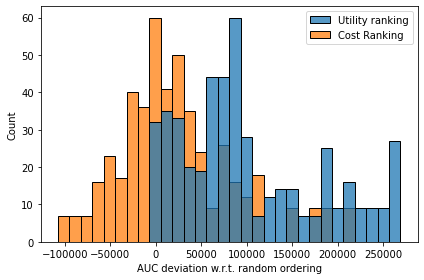

In [18]:
fig, ax = plt.subplots()
sns.histplot(auc_distributions, ax=ax, bins=30)
ax.set(xlabel='AUC deviation w.r.t. random ordering')
fig.tight_layout()
fig.savefig(controller_output / 'shared_histogram.png')

In [24]:
fig, ax = plt.subplots()
sns.regplot(data=low_c_estimates_df, x='issues_in_run', y='auc_vs_random', label='Cost', ci=95, ax=ax)
ax.set(xlabel='Number of issues in run', ylabel='AUC deviation w.r.t. random ordering');
fig.tight_layout()
fig.savefig(controller_output / 'auc_vs_n_issues_cost.png', dpi=300)

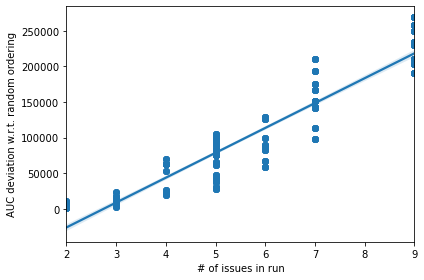

In [ ]:
fig, ax = plt.subplots()
sns.regplot(data=low_u_estimates_df, x='issues_in_run', y='auc_vs_random', label='Cost', ci=95, ax=ax)
ax.set(xlabel='Number of issues in run', ylabel='AUC deviation w.r.t. random ordering');
fig.tight_layout()
fig.savefig(controller_output / 'auc_vs_n_issues_utility.png', dpi=300)

### Inside indiviual runs

In [21]:
def plot_strategies_per_run(df, run):
    fig, ax = plt.subplots()
    plotting_map = {
        'Random Ranking': 'random',
        'Cost Ranking': 'cost',
        'Utility Ranking': 'utility',
    }

    for label, strategy in plotting_map.items():
        ranked_issues = calculate_estimated_utility_within_run(df, run, strategy)\
            .reset_index(drop=True)\
            .reset_index()\
            .rename(columns={'index': 'fixed_issues'})
        ranked_issues['fixed_issues'] += 1
        ranked_issues.loc[-1] = {
            'fixed_issues': 0,
            'run': ranked_issues['run'][0],
            'fix_status': ranked_issues['fix_status'][0],
            'estimated_system_utility': ranked_issues['estimated_system_utility'][0] - ranked_issues['predicted_optimal_utility'][0],
            'auc': 0
        }  # adding a row
        ranked_issues.index = ranked_issues.index + 1  # shifting index
        ranked_issues.sort_index(inplace=True)
        ranked_issues.plot(
            x='fixed_issues',
            y='estimated_system_utility',
            drawstyle='steps-post',
            ax=ax,
            label=label,
            alpha=0.75
    )

    ax.set(
        xlabel='Addressed Issues',
        ylabel='System Utility',
        title=f'Run {run}: System Utility (detail)',
    )
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.tight_layout()
    return fig

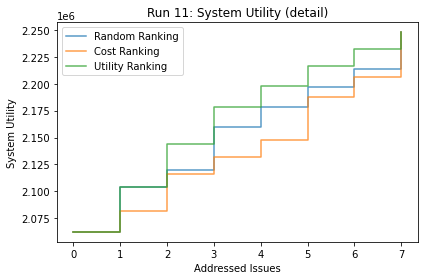

In [22]:
plot_strategies_per_run(low_u_df, 11).savefig(controller_output / 'run_11.png', dpi=300)

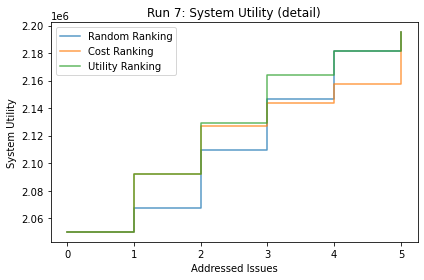

In [23]:
plot_strategies_per_run(low_u_df, 7).savefig(controller_output / 'run_7.png', dpi=300)